# The Bayesian workflow in `sbi`

In this tutorial, we will perform a full Bayesian workflow with `sbi` using the Lotka-Volterra simulator.  

Here is a code-snippet that you will learn to understand:

```python
from sbi.neural_nets import posterior_nn
from sbi.inference import NPE, DirectPosterior
from sbi.diagnostics import SBC

num_simulations = 1000
theta = prior.sample((num_simulations,))
x = simulate(theta)

# Train neural network.
inference = NPE(prior)
posterior_net = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

# Diagnostics with SBC.
thetas = prior.sample((num_sbc_samples,))
xs = simulator(thetas)
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=1_000,
)
```

Let's get started!

## Defining the simulator and prior

In this example, we will use the Lotka-Volterra simulator. This simulator models the population of prey and predator, given four parameters:

- $\alpha$: Prey birth rate: The rate at which prey reproduce in the absence of predators
- $\beta$: Predation rate: The rate at which predators consume prey, reducing the prey population
- $\delta$: Predator reproduction rate: The rate at which predators reproduce based on prey consumption
- $\gamma$: Predator death rate: The rate at which predators die in the absence of prey

In [1]:
import numpy as np

_ = np.random.seed(0)

def lotka_volterra(y, alpha, beta, delta, gamma):
    prey, predator = y
    dprey_dt = alpha * prey - beta * prey * predator
    dpredator_dt = delta * prey * predator - gamma * predator
    return np.asarray([dprey_dt, dpredator_dt])

def simulate(parameters):
    alpha = parameters[0]
    beta = parameters[1]
    delta = parameters[2]
    gamma = parameters[3]

    y0 = np.asarray([40.0, 9.0])  # Initial populations
    t_span = 200  # Total simulation time
    dt = 0.1  # Time step

    timesteps = int(t_span / dt)
    y = np.zeros((timesteps, 2))
    y[0] = y0

    for i in range(1, timesteps):
        y[i] = y[i-1] + lotka_volterra(y[i-1], alpha, beta, delta, gamma) * dt

    return y

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


Let's inspect this simulator a set of example parameters:

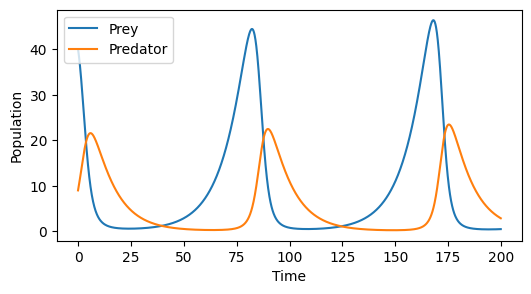

In [2]:
import matplotlib.pyplot as plt

time_vec = np.arange(0, 200, 0.1)
observation = simulate(np.asarray([0.1, 0.02, 0.01, 0.1]))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
_ = ax.plot(time_vec, observation)
_ = ax.legend(["Prey", "Predator"])
_ = ax.set_xlabel("Time")
_ = ax.set_ylabel("Population")

Typically, we will not be able to observe populations exactly, but only with noise. In addition, in this example, we will aim to reproduce summary statistics of these simulations. Let's add noise and define these statistics:

In [3]:
def summarize_simulation(simulation_result):
    observation_noise = np.reshape(
        np.random.randn(2000 * 2),
        (2000, 2)
    )
    noisy_sim = simulation_result + observation_noise

    prey_population = noisy_sim[:, 0]
    predator_population = noisy_sim[:, 1]
    summary = [
        np.max(prey_population).item(),
        np.max(predator_population).item(),
        np.mean(prey_population).item(),
        np.mean(predator_population).item()
    ]
    return np.asarray(summary)

> `sbi` can also perform inference given the raw time series with an _embedding network_. This is described in [this how-to guide]().

Let's define a prior over the four parameters. In this case, we assume a uniform prior:

In [4]:
import torch

_ = torch.manual_seed(42)
from sbi.utils import BoxUniform

lower_bound = torch.as_tensor([0.05, 0.01, 0.005, 0.005])
upper_bound = torch.as_tensor([0.15, 0.03, 0.03, 0.15])
prior = BoxUniform(low=lower_bound, high=upper_bound)

/mnt/lustre/work/macke/mgloeckler90/miniconda3/envs/sbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generating the training dataset

Using the prior and the simulator, we can generate simulated data. We first generate prior samples:

In [5]:
theta = prior.sample((10_000,))

As before, you can run simulations offline (e.g. on a cluster). For this example, we parallelize simulations via `joblib`. We define a small helper to run simulations in parallel:

In [6]:
from joblib import Parallel, delayed


def parallel_simulate(theta):
    # Our simulator uses numpy, but prior samples are in PyTorch.
    theta_np = theta.numpy()

    num_workers = 8
    simulation_outputs = Parallel(n_jobs=num_workers)(
        delayed(simulate)(batch)
        for batch in theta_np
    )
    return np.asarray(simulation_outputs)

And we can run the simulations:

In [7]:
# This takes a few seconds.
simulation_outputs = parallel_simulate(theta)
x = torch.as_tensor(np.asarray([summarize_simulation(sim) for sim in simulation_outputs]), dtype=torch.float32)

print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([10000, 4])
x.shape torch.Size([10000, 4])


Having generated this dataset, we recommend that you briefly check whether the simulations roughly cover the observation. Let's first compute the summary statistics of the observation:

In [8]:
x_obs = summarize_simulation(observation)
print(x_obs.shape)

(4,)


And then we can visualize simulation outputs and the observation:

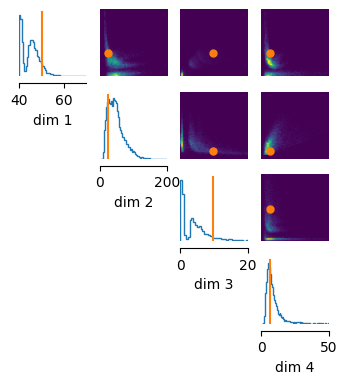

In [9]:
from sbi.analysis import pairplot

_ = pairplot(
    samples=x,
    points=x_obs[None, :],  # `points` needs a batch dimension.
    limits=[[40, 70], [0, 200], [0, 20], [0, 50]],
    figsize=(4, 4),
)

Notice two things:
- First, the simulations (blue histogram) roughly cover the observation (orange line). This is a good sign. If the observation is far outside of the simulations, `sbi` will likely fail. Change your prior or simulator.
- Second, there are no extreme outliers in the simulation data. Remember that we will train a neural network on simulated data. If there are extreme outliers, this might lead to poor neural network convergence. For NPE, outliers can be safely ignored (i.e. removed from the dataset).  

## Setting up the neural network

We now want to set up a neural network for this example. For this example, we will use Neural Posterior Estimation (NPE) with a neural spline flow (`nsf`) as density estimator. See [here](https://sbi.readthedocs.io/en/latest/sbi.html#neural-nets) for the collection of neural networks and [here](https://sbi.readthedocs.io/en/latest/how_to_guide/03_choose_neural_net.html) for a guide on which methods to choose.

In [10]:
from sbi.inference import NPE

inference = NPE(density_estimator="nsf")

We then train the network on our simulations:

In [11]:
posterior_net = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 170 epochs.

We can check the convergence of the training loop by inspecting its loss curve:

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/mnt/lustre/work/macke/mgloeckler90/sbi/docs/tutorials/sbi-logs/NPE_C/2025-08-14T15_29_52.622685' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.



Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


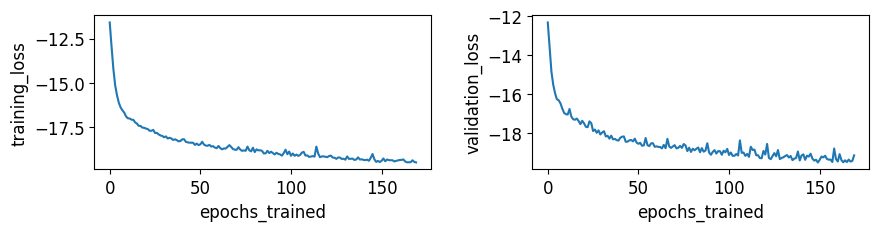

In [12]:
from sbi.analysis import plot_summary

_ = plot_summary(
    inference,
    tags=["training_loss", "validation_loss"],
    figsize=(10, 2),
)
# All training logs are available in `trainer.summary`.

In this case, the validation loss seems to still be going down, so it might be worth setting a higher value for `.train(stop_after_epochs=30)` (default value is 20). This parameter sets how many epochs must pass for without the validation loss reaching a new minimum. For this example, we will not retrain.

After training, we can build the `posterior`:

In [13]:
posterior = inference.build_posterior()
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


/mnt/lustre/work/macke/mgloeckler90/sbi/sbi/inference/trainers/base.py:578: FutureWarning: The following arguments are deprecated and will be removed in a future version: mcmc_method, vi_method. Please use `posterior_parameters` instead. Refer to this guide for details:
https://sbi.readthedocs.io/en/latest/how_to_guide/19_posterior_parameters.html#
  self._raise_deprecation_warning(deprecated_params, **kwargs)


> For NPE, the `posterior` and the `posterior_net` are almost identical. The `posterior_estimator` merely includes convenience functionality. For example, it automatically rejects samples outside of the prior support, or it can compute the maximum-a-posteriori estimate with `.map()`

## Inferring the posterior

Let's aim to infer the posterior given our observation:

In [14]:
print("Observation: ", x_obs)

Observation:  [50.2497606  24.65478002  9.52736287  6.05178971]


We can sample from the NPE-posterior:

In [15]:
samples = posterior.sample((1_000,), x=x_obs)

Drawing 1000 posterior samples for 1 observations:   0%|          | 0/1000 [00:00<?, ?it/s]/mnt/lustre/work/macke/mgloeckler90/miniconda3/envs/sbi/lib/python3.12/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2264.)
  outputs, _ = torch.triangular_solve(
Drawing 1000 posterior samples for 1 observations: 100%|██████████| 1000/1000 [00:00<00:00, 19795.94it/s]


> Again, you can infer the posterior distribution for any observation $x_{obs}$ without having to run new simulations and without having to re-train (amortization).

## Visualizing the posterior

Next, we visualize these posterior samples with the `pairplot` function:

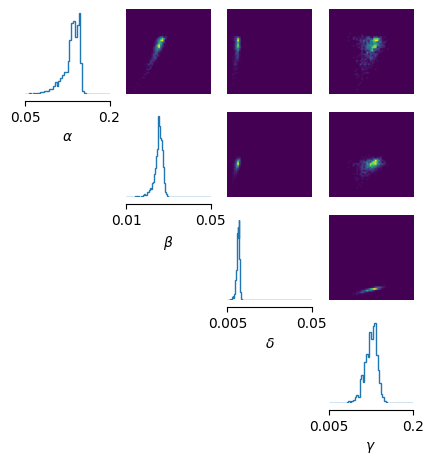

In [16]:
from sbi.analysis import pairplot

_ = pairplot(
    samples,
    limits=[[0.05, 0.2], [0.01, 0.05], [0.005, 0.05], [0.005, 0.2]],
    ticks=[[0.05, 0.2], [0.01, 0.05], [0.005, 0.05], [0.005, 0.2]],
    figsize=(5, 5),
    labels=[r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]
)

## Diagnosing potential issues in the posterior

How do we know that the posterior is correct? The `sbi` toolbox implements a wide range
of methods that diagnose potential issues (more detail in [this how-to guide](https://sbi.readthedocs.io/en/latest/how_to_guide/14_choose_diagnostic_tool.html)). In this tutorial, we will perform _posterior predictive checks_ (PPC) and we will perform _simulation-based calibration_ (SBC).

### Posterior predictive checks

Let's first perform posterior predictive checks. For these, we simulate posterior samples and compare them to the observation.

In [17]:
posterior_samples = posterior.sample((10,), x=x_obs)
posterior_predictives = parallel_simulate(posterior_samples)

posterior_predictive_summary_stats = torch.as_tensor(
    np.asarray([summarize_simulation(sim) for sim in simulation_outputs]),
    dtype=torch.float32
)

Drawing 10 posterior samples for 1 observations: 100%|██████████| 10/10 [00:00<00:00, 1229.17it/s]


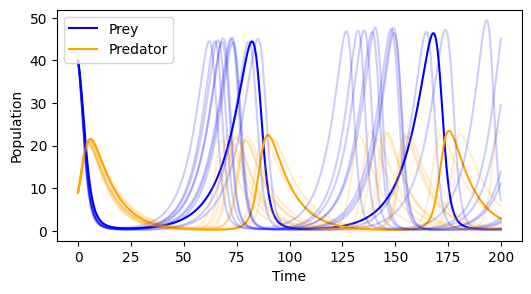

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
_ = ax.plot(time_vec, observation[:, 0], c="b")
_ = ax.plot(time_vec, observation[:, 1], c="orange")
for i in range(10):
    _ = ax.plot(time_vec, posterior_predictives[i, :, 0], c="b", alpha=0.2)
    _ = ax.plot(time_vec, posterior_predictives[i, :, 1], c="orange", alpha=0.2)
_ = ax.legend(["Prey", "Predator"])
_ = ax.set_xlabel("Time")
_ = ax.set_ylabel("Population")

As you can see, the posterior predictives (light blue and light orange) look similar to the observation (blue and orange). They do not look exactly the same, but this is expected: we only used the maximum and mean of the two traces as summary statistic. If you want a closer fit, define more summary statistics, or [use the full time series with an embedding network](https://sbi.readthedocs.io/en/latest/how_to_guide/04_embedding_networks.html).

### Simulation-based calibration

Posterior-predictive checks are an ad-hoc heuristic for assessing posterior quality. Simulation-based calibration (SBC) provides a _quantitative_ assessment of posterior quality. It allows you to check, for every parameter, whether the parameter is estimated as (on average) to low, to high, and whether it has too low or two high uncertainty. To run SBC, you first have to generate more simulations based on prior samples:

In [19]:
num_sbc_samples = 200  # choose a number of sbc runs, should be ~100s

prior_samples = prior.sample((num_sbc_samples,))

prior_predictives = parallel_simulate(prior_samples)
prior_predictive_summary_stats = torch.as_tensor(
    np.asarray([summarize_simulation(sim) for sim in prior_predictives]),
    dtype=torch.float32
)

SBC is implemented in `sbi` for your use on any `sbi` posterior. To run it, we only need to call `run_sbc` with appropriate parameters.

In [20]:
from sbi.diagnostics import run_sbc

# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    prior_samples,
    prior_predictive_summary_stats,
    posterior,
    reduce_fns=lambda theta, x: -posterior.log_prob(theta, x),
    num_posterior_samples=num_posterior_samples,
    use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
)

Sampling 200 times (1000,) posterior samples.:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating ranks for 200 SBC samples: 100%|██████████| 200/200 [00:32<00:00,  6.14it/s]


> For amortized neural posteriors (like in this tutorial), execution of `sbc` is expected to be fast. For posteriors that conduct inference with MCMC and hence are slow, `run_sbc` exposes the use of multiple internal parallel workers to the user. To use this feature, add `num_workers = 2` to the parameters for use of two workers. See the API documentation for details.


If the posterior approximation is faithful, the `ranks` should be uniformly distributed. We can evaluate this with by plotting a histogram of the resulting ranks:

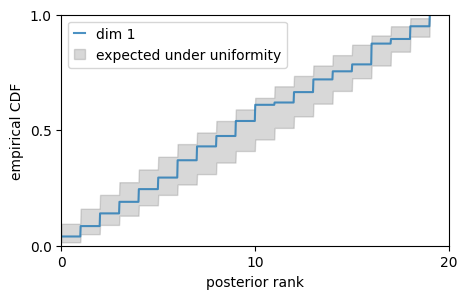

In [21]:
from sbi.analysis.plot import sbc_rank_plot

fig, ax = sbc_rank_plot(
    ranks,
    num_posterior_samples,
    plot_type="cdf",
    num_bins=20,
    figsize=(5, 3),
)

The gray are marks the region which is still sufficiently uniform (meaning that we cannot reject the null hypothesis that the samples are uniform). In this case, all ranks (in red) are within this gray band. This is a good sign, but it is only a necessary---but not a sufficient---condition for the posterior to be correct. To this end, `sbi` implements a wide range of diagnostic methods, which are described [here](https://sbi.readthedocs.io/en/latest/how_to_guide/14_choose_diagnostic_tool.html).

## Next steps

Next, we recommend that you check our [how-to guide](https://sbi.readthedocs.io/en/latest/how_to_guide.html) for brief tutorials on specific features, our [advanced tutorials](https://sbi.readthedocs.io/en/latest/advanced_tutorials.html) for detailed explanations, or our [API reference](https://sbi.readthedocs.io/en/latest/sbi.html), which provides a complete list of all features in the `sbi` toolbox.